In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import random



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xai-updatedataset/train_df (1).csv
/kaggle/input/xai-updatedataset/test_df (1).csv


In [2]:
train_df = pd.read_csv("/kaggle/input/xai-updatedataset/train_df (1).csv")
test_df = pd.read_csv("/kaggle/input/xai-updatedataset/test_df (1).csv")
X_train = train_df["text"]
y_train = train_df["label"]
X_test = test_df["text"]
y_test = test_df["label"]

In [3]:
vectorizer = TfidfVectorizer(max_features=32000)
X_tfidf = vectorizer.fit_transform(train_df['text']).toarray()

In [4]:
train_corpus = [text.split() for text in X_train]

In [5]:
w2v_model = Word2Vec(
    sentences=train_corpus,  # The input corpus, where each sentence is tokenized into a list of words.
    vector_size=100,         # The dimensionality of the word vectors (size of each word embedding).
    window=5,                # The maximum distance between the current and predicted word in a sentence (context window).
    min_count=2,             # Ignores words that appear less than 2 times in the corpus.
    workers=4,               # Number of worker threads used for training (parallelism).
    sg=0                     # Specifies the training algorithm: 0 for CBOW (Continuous Bag of Words), 1 for Skip-gram.
)

In [6]:
def text_to_vector(corpus, model):
    vectors = []
    for words in corpus:
        word_vecs = [model.wv[word] for word in words if word in model.wv]
        if len(word_vecs) > 0:
            vectors.append(np.mean(word_vecs, axis=0))
        else:
            vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)

In [7]:
X_train_vectors = text_to_vector(train_corpus, w2v_model)

In [8]:
scaler = MinMaxScaler()
X_train_vectors = scaler.fit_transform(X_train_vectors)

X_tfidf_scaled = scaler.fit_transform(X_tfidf)

In [9]:
pca = PCA(n_components=2)
X_2d_w2v = pca.fit_transform(X_train_vectors)

X_tfidf_2d = pca.fit_transform(X_tfidf_scaled)


In [10]:
labels = train_df['label'].values

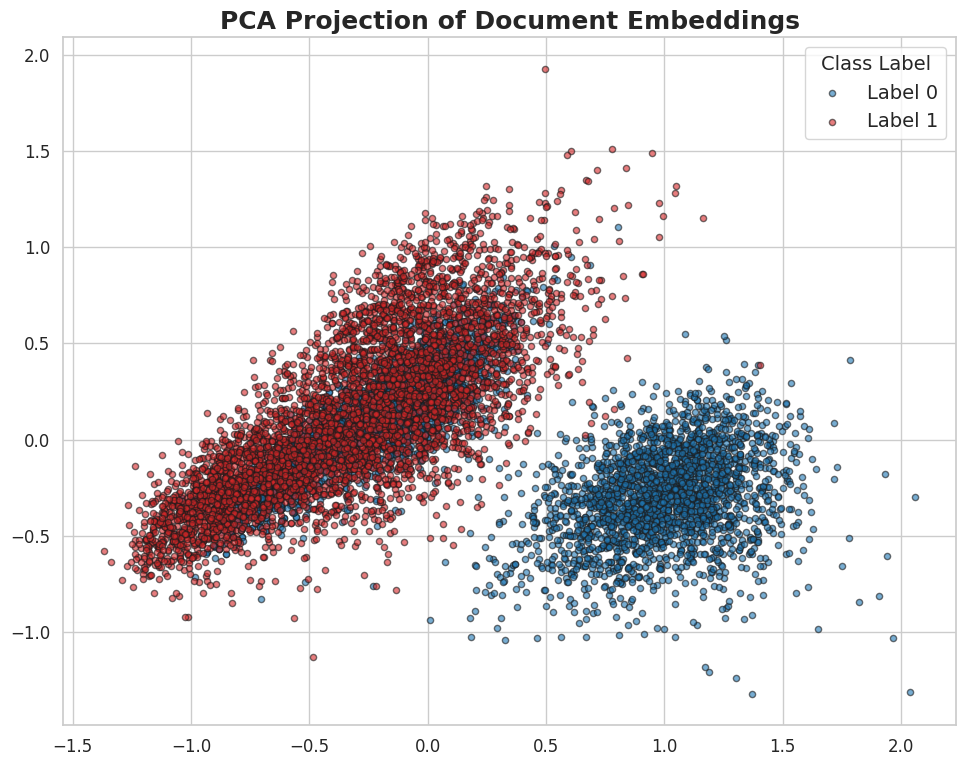

In [11]:
sns.set(style="whitegrid", font_scale=1.5)

plt.figure(figsize=(10, 8))

palette = {0: "#1f77b4", 1: "#d62728"}  # blue & red for clarity

for lbl in np.unique(labels):
    idxs = labels == lbl
    plt.scatter(
        X_2d_w2v[idxs, 0],
        X_2d_w2v[idxs, 1],
        label=f"Label {lbl}",
        alpha=0.6,
        edgecolors='k',
        s=20,  # marker size
        color=palette[lbl]
    )

plt.title("PCA Projection of Document Embeddings", fontsize=18, weight='bold')

# Legend
plt.legend(title="Class Label", fontsize=14, title_fontsize=14, loc="best")

# Cleaner ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Tight layout
plt.tight_layout()
plt.show()

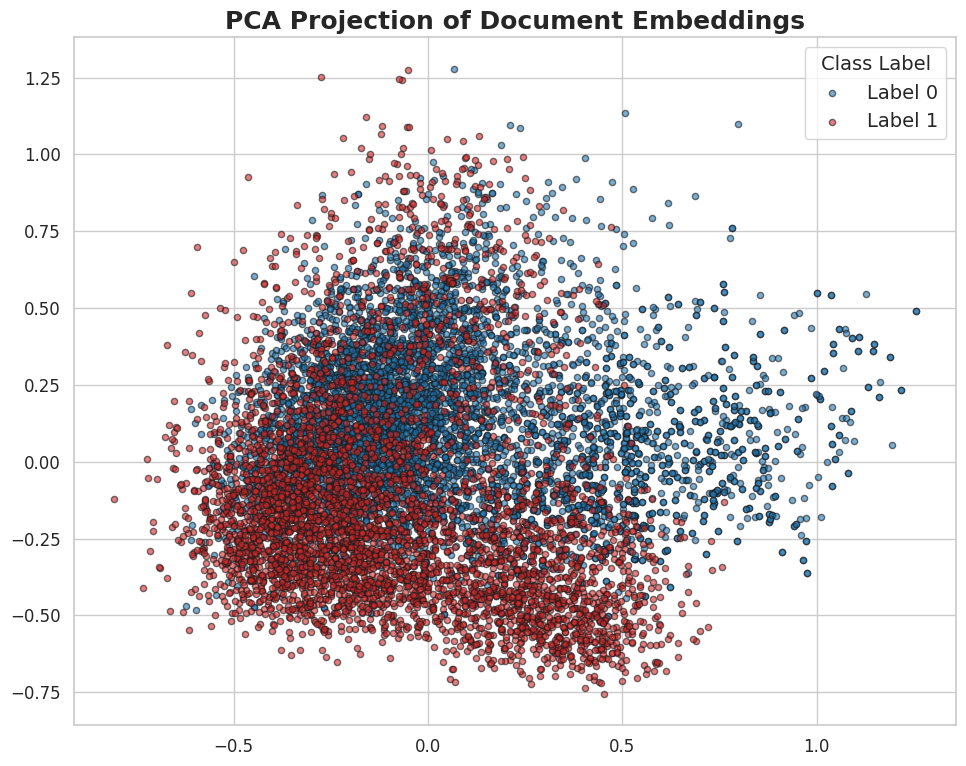

In [12]:
sns.set(style="whitegrid", font_scale=1.5)

plt.figure(figsize=(10, 8))

palette = {0: "#1f77b4", 1: "#d62728"}  # blue & red for clarity

for lbl in np.unique(labels):
    idxs = labels == lbl
    plt.scatter(
        X_tfidf_2d[idxs, 0],
        X_tfidf_2d[idxs, 1],
        label=f"Label {lbl}",
        alpha=0.6,
        edgecolors='k',
        s=20,  # marker size
        color=palette[lbl]
    )

plt.title("PCA Projection of Document Embeddings", fontsize=18, weight='bold')

# Legend
plt.legend(title="Class Label", fontsize=14, title_fontsize=14, loc="best")

# Cleaner ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Tight layout
plt.tight_layout()
plt.show()

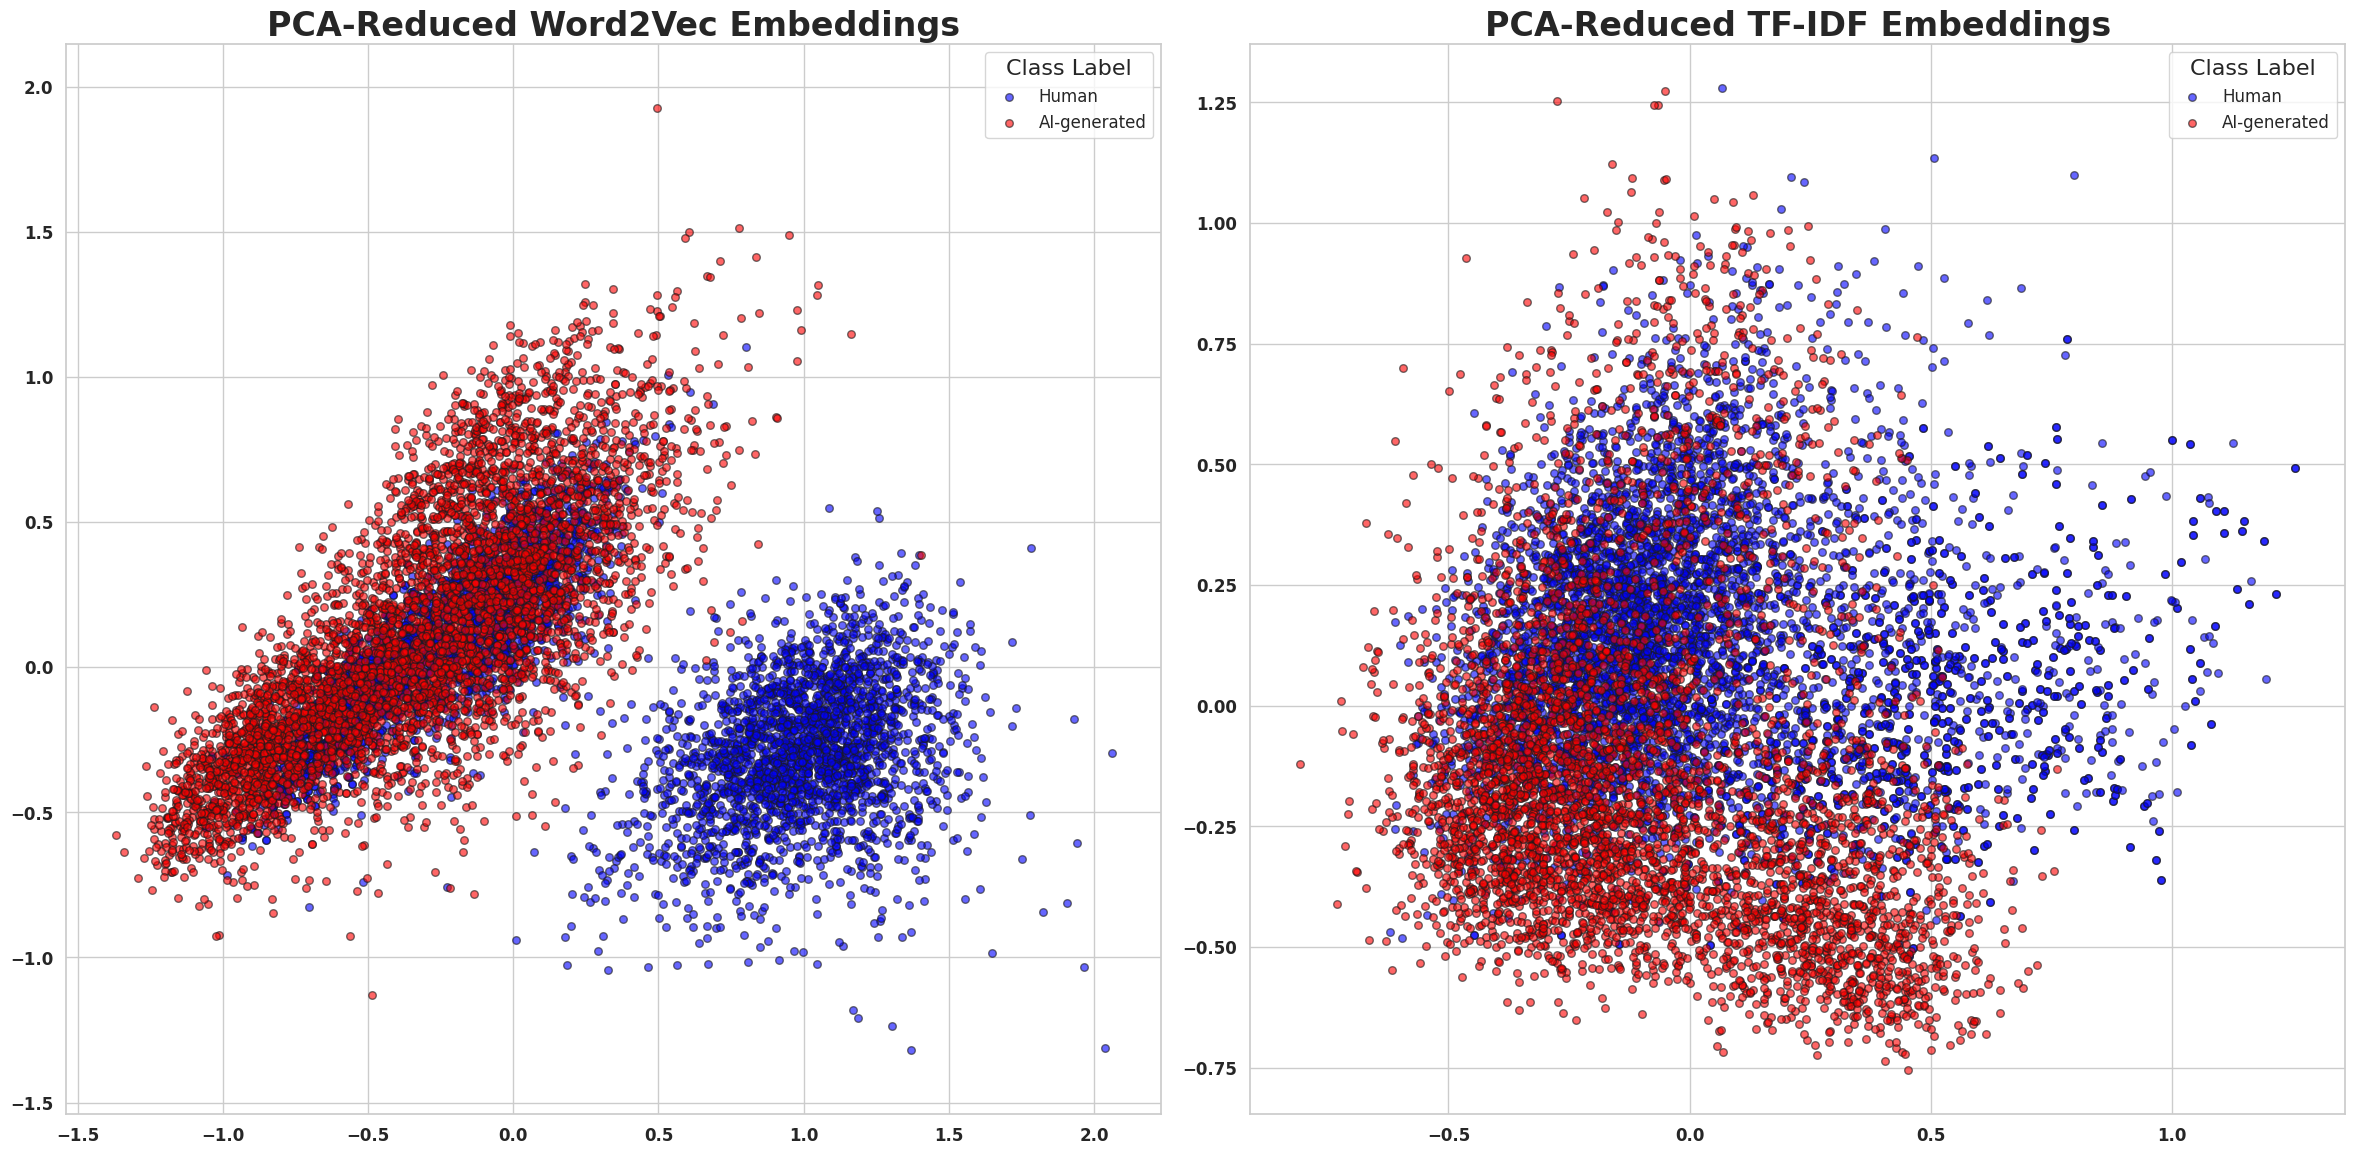

In [13]:
sns.set(style="whitegrid", font_scale=1.8)

palette = {0: "blue", 1: "red"}  # blue & red for clarity

plt.figure(figsize=(24, 12))  # wider for side-by-side

# --------------------------
# (a) Word2Vec PCA
# --------------------------
plt.subplot(1, 2, 1)
plt.axis("equal")
for lbl, name in zip(np.unique(labels), ["Human", "AI-generated"]):
    idxs = labels == lbl
    plt.scatter(
        X_2d_w2v[idxs, 0],  # your Word2Vec PCA 2D vectors
        X_2d_w2v[idxs, 1],
        label=name,
        alpha=0.6,
        edgecolors='k',
        s=30,
        color=palette[lbl]
    )
plt.title("PCA-Reduced Word2Vec Embeddings", fontsize=24, weight='bold')
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.legend(title="Class Label", fontsize=12, title_fontsize=16)

# --------------------------
# (b) TF-IDF PCA
# --------------------------
plt.subplot(1, 2, 2)
plt.axis("equal")
for lbl, name in zip(np.unique(labels), ["Human", "AI-generated"]):
    idxs = labels == lbl
    plt.scatter(
        X_tfidf_2d[idxs, 0],  # your TF-IDF PCA 2D vectors
        X_tfidf_2d[idxs, 1],
        label=name,
        alpha=0.6,
        edgecolors='k',
        s=30,
        color=palette[lbl]
    )
plt.title("PCA-Reduced TF-IDF Embeddings", fontsize=24, weight='bold')
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.legend(title="Class Label", fontsize=12, title_fontsize=16)

plt.tight_layout()
plt.show()
